In [169]:
get_ipython().run_line_magic('matplotlib', 'notebook')
import sympy as sp
from math import e, sin, cos, log, pi, tan
import scipy.linalg as la
import numpy as np
from functools import partial
import matplotlib.pyplot as plt

In [172]:
def get_crit(func: sp.Matrix, X: list):
    """
    func: sympy.Matrix(['x + y']),
    X: [sympy.Symbol('x'), sympy.Symbol('y')]
    return critical points
    """
    gradf = sp.simplify(func.jacobian(X))
    return sp.solve(gradf, X, dict=True)

In [47]:
def filter_point(point: list, x_min, x_max, y_min, y_max):
    """
    point: [(1, 2), (2, 3)] – list of tuples, critical points for filtering
    x_min, x_max, y_min, y_max – int or float, constraints for variables
    """
    x, y = point.values()
    if x_min <= x <= x_max and y_min <= y <= y_max:
        return True
    return False

In [40]:
def type_point(func, X, x0):
    """
    func: sympy.Matrix(['x + y']),
    X: [sympy.Symbol('x'), sympy.Symbol('y')],
    x0: (1, 2) – tuple of int or float numbers, critical point 
    return type of critical points
    """
    hessianf = sp.simplify(sp.hessian(func, X))
    H = np.array(hessianf.subs(dict(zip(X, x0)))).astype('float')
    l, v = la.eig(H)
    if(np.all(np.greater(l, np.zeros(2)))):
       return 'minimum'
    elif(np.all(np.less(l, np.zeros(2)))):
       return 'maximum'
    else:
       return 'saddle'

In [41]:
def right_func(func, X):
    for symbol in func:
        if symbol.isalpha() and sp.Symbol(symbol) not in X:
            return False  # неизвестная переменная в функции
    return True
    # еще надо обработать пропущенный знак типа 2x1 + 15x2 

In [170]:
def get_data():
    data = dict()
    data['X'] = sp.symbols(input('Введите названия переменных (x y): ').split())
    assert len(data['X']) == 2, 'переменные заданы неверно'

    f = input('Введите функцию (y*x+2): ')
    assert right_func(f, data['X']), 'функция задана неверно неверно' 
    data['func'] = sp.Matrix([f])

    data['limit'] = int(input('Есть ли ограничения? (1 – да, 0 – нет): '))
    if data['limit']:
        str_x = 'Введите ограничения для x (-10 10): '
        str_y = 'Введите ограничения для y (-10 10): '
        try:
            data['x_min'], data['x_max'] = map(lambda x: int(x), input(str_x).split())
            data['y_min'], data['y_max'] = map(lambda y: int(y), input(str_y).split())
        except ValueError:
            raise Exception('ограничения заданы неверно')
        assert data['x_min'] < data['x_max'], 'границы для ограничения x перепутаны'
        assert data['y_min'] < data['y_max'], 'границы для ограничения y перепутаны'

    return data

In [66]:
# Написать ф-ию для отрисовки 1 графика
def get_extremums():
    """
    returns a tuple from the source data and the results of the function. 
    data: dict - dictionary of source data, stores the name of variables, 
    function, constraints. 
    points: list – a list of tuples, each element stores a point, 
    the value of the function at the point and the type of extremum.
    """
    data = get_data()
    crit = get_crit(data['func'], data['X'])
    if data['limit']:
        f = partial(filter_point, x_min=data['x_min'], x_max=data['x_max'], 
                                  y_min=data['y_min'], y_max=data['y_max'])
        crit = list(filter(f, crit))
    if len(crit) > 40:
        n = int(input('Точек больше 40, сколько вывести? '))
        crit = crit[:n]
    points = []
    for x in crit:
        x1, x2 = x.values()
        z = data['func'].subs(x)[0]
        type_x = type_point(data['func'], data['X'], x.values())
        points.append(((x1, x2), z, type_x))
    # points = [(x.values(), type_point(data['func'], data['X'], x.values())) for x in crit]
    return data, points

In [166]:
def show_chart(data, points):
    func = data['func']
    args = data['X']
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    x_min = int(min(p[0][0] for p in points)) - 5
    x_max = int(max(p[0][0] for p in points)) + 5
    y_min = int(min(p[0][1] for p in points)) - 5
    y_max = int(max(p[0][1] for p in points)) + 5
    x_linsp = np.linspace(x_min, x_max, 100)
    y_linsp = np.linspace(y_min, y_max, 100)
    x_linsp, y_linsp = np.meshgrid(x_linsp, y_linsp)
    z_linsp = sp.lambdify(args, func)(x_linsp, y_linsp)[0][0]
    x = [float(p[0][0]) for p in points]
    y = [float(p[0][1]) for p in points]
    z = [float(p[1]) for p in points]
    ax.plot_surface(x_linsp, y_linsp, z_linsp, cmap=plt.cm.coolwarm, alpha=0.5)
    plt.title(f'z{args[0], args[1]} = {func[0]}', fontsize=11)
    ax.set_xlabel(args[0], color='blue', fontsize=20)  
    ax.set_ylabel(args[1], color='blue', fontsize=20) 
    ax.set_zlabel('z', color='blue', fontsize=20)
    ax.scatter(x, y, z, c='red', s=50, alpha=1, label='extremums')
    plt.legend(fontsize='small')
    plt.show()

In [91]:
data, points = get_extremums()  # x1**3+3*x1*x2**2-15*x1-12*x2+1
points

Введите название переменных (x y): x y
Введите функцию (y*x+2): x**3+3*x*y**2-15*x-12*y+1
Есть ли ограничения? (1 – да, 0 – нет): 0


[((-2, -1), 'func(x1, x2) = 29', 'maximum'),
 ((-1, -2), 'func(x1, x2) = 27', 'saddle'),
 ((1, 2), 'func(x1, x2) = -25', 'saddle'),
 ((2, 1), 'func(x1, x2) = -27', 'minimum')]

In [67]:
data, points = get_extremums()
points

Введите названия переменных (x y): x y 
Введите функцию (y*x+2): x**3+3*x*y**2-15*x-12*y+1
Есть ли ограничения? (1 – да, 0 – нет): 1
Введите ограничения для x (-10 10): 0 10
Введите ограничения для y (-10 10): 0 10


[((1, 2), -25, 'saddle'), ((2, 1), -27, 'minimum')]

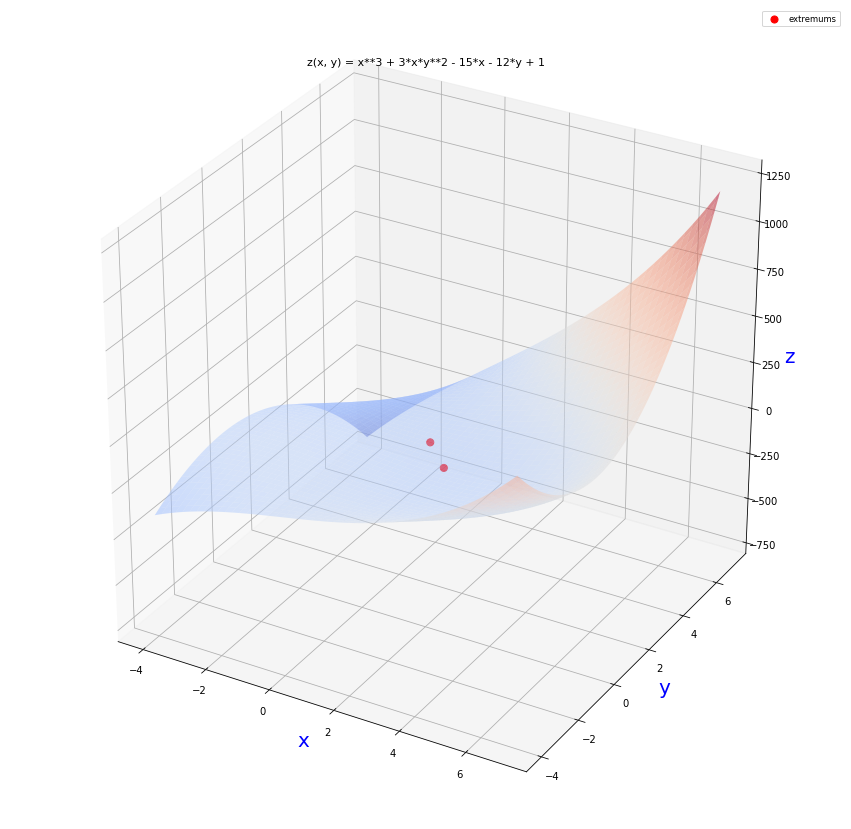

In [167]:
show_chart(data, points)